In [26]:
import math
import time
import configparser

import numpy as np
import sklearn.linear_model
import sklearn.metrics
from matplotlib import pyplot as plt

from solml import load, cnn
import split
import get_info

%matplotlib inline

In [27]:
config = configparser.ConfigParser()
config.read('../config.ini')
models_filename = config['main']['models']

In [2]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.get_sets()

In [3]:
bounding_boxes = get_info.get_bounding_box(train_ids)
cnn_train = cnn.get_cnn_features_list(train_ids, bounding_boxes)
bounding_boxes = get_info.get_bounding_box(val_ids)
cnn_val = cnn.get_cnn_features_list(val_ids, bounding_boxes)
bounding_boxes = get_info.get_bounding_box(test_ids)
cnn_test = cnn.get_cnn_features_list(test_ids, bounding_boxes)

In [4]:
class_weight=None # or 'balanced'

## CNN

In [5]:
n_C = 20
C_list = np.logspace(-10, 10, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C, class_weight=class_weight)
    t = time.time()
    model.fit(cnn_train, train_labels)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(cnn_val)
    errors[i] = (val_labels!=predictions).sum()/len(val_labels)

LR took 0.659360 seconds.
LR took 0.865151 seconds.
LR took 1.271335 seconds.
LR took 1.739219 seconds.
LR took 2.997964 seconds.
LR took 5.926404 seconds.
LR took 12.970935 seconds.
LR took 27.505175 seconds.
LR took 47.353257 seconds.
LR took 49.265185 seconds.
LR took 48.598923 seconds.
LR took 52.948556 seconds.
LR took 54.130324 seconds.
LR took 56.623516 seconds.
LR took 52.040903 seconds.
LR took 52.512075 seconds.
LR took 51.838083 seconds.
LR took 51.937793 seconds.
LR took 52.283647 seconds.
LR took 52.188627 seconds.


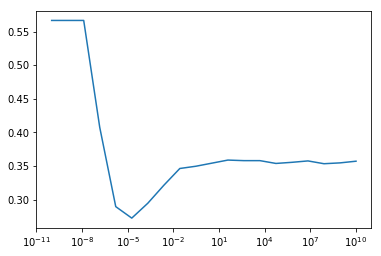

In [6]:
plt.plot(C_list, errors)
plt.xscale('log')

In [7]:
#i_opt = np.argmin(errors)
C_opt = 0.000018#C_list[i_opt]
print('optimal C : %f'%C_opt)
model_cnn = sklearn.linear_model.LogisticRegression(penalty='l2', C=C_opt, class_weight=class_weight)
t = time.time()
model_cnn.fit(cnn_train, train_labels)
print("LR took %f seconds."%(time.time()-t))
predictions = model_cnn.predict(cnn_test)
err = (test_labels!=predictions).sum()/len(test_labels)

optimal C : 0.000018
LR took 6.380751 seconds.


In [8]:
err

0.24958333333333332

In [9]:
cnn_proba_val = model_cnn.predict_proba(cnn_val)[:,:-1]
cnn_proba_test = model_cnn.predict_proba(cnn_test)[:,:-1]

## LR

In [12]:
l = 6
color = False
train_reduc, val_reduc, test_reduc = split.load_images(train_ids, val_ids, test_ids, l, color)

In [13]:
model_lr = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10, class_weight=class_weight)
model_lr.fit(train_reduc, train_labels)
predictions = model_lr.predict(val_reduc)
error = (val_labels!=predictions).sum()/len(val_labels)
error

0.43137254901960786

In [14]:
reduc_proba_val = model_lr.predict_proba(val_reduc)[:,:-1]
reduc_proba_test = model_lr.predict_proba(test_reduc)[:,:-1]

In [15]:
val_mix = np.concatenate([cnn_proba_val, reduc_proba_val], axis=1)
test_mix = np.concatenate([cnn_proba_test, reduc_proba_test], axis=1)

In [16]:
model_ensemble = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10, class_weight=class_weight)
model_ensemble.fit(val_mix, val_labels)
predictions = model_ensemble.predict(test_mix)
error = (test_labels!=predictions).sum()/len(test_labels)
error

0.23958333333333334

In [17]:
probas = model_ensemble.predict_proba(test_mix)

## Confusion matrix

In [18]:
sklearn.metrics.confusion_matrix(test_labels, predictions)

array([[922,  18,  16,  84],
       [ 44, 399,  11,  77],
       [ 31,  31, 166,  34],
       [134,  74,  21, 338]])

## Confidence

In [19]:
confidence = np.max(probas, axis=1)

(array([  1.,   1.,   1.,   1.,   1.,   2.,   1.,   6.,  10.,   6.,   7.,
          9.,  15.,   8.,   7.,  11.,   5.,  10.,  12.,  15.,   9.,  13.,
         20.,  15.,  17.,  15.,  30.,  17.,  20.,  15.,  13.,  23.,  17.,
         16.,  18.,  19.,  23.,  17.,  25.,  15.,  27.,  23.,  22.,  16.,
         23.,  18.,  15.,  20.,  26.,  18.,  18.,  25.,  19.,  20.,  22.,
         12.,  12.,  21.,  21.,  20.,  20.,  25.,  28.,  18.,  25.,  28.,
         30.,  19.,  25.,  26.,  27.,  27.,  35.,  26.,  28.,  34.,  32.,
         31.,  36.,  31.,  37.,  34.,  31.,  20.,  42.,  43.,  49.,  48.,
         44.,  47.,  48.,  64.,  63.,  66.,  70.,  68.,  58.,  63.,  44.,
         26.]),
 array([ 0.29406663,  0.30071797,  0.30736931,  0.31402065,  0.32067199,
         0.32732333,  0.33397468,  0.34062602,  0.34727736,  0.3539287 ,
         0.36058004,  0.36723138,  0.37388272,  0.38053406,  0.3871854 ,
         0.39383675,  0.40048809,  0.40713943,  0.41379077,  0.42044211,
         0.42709345,  0.43

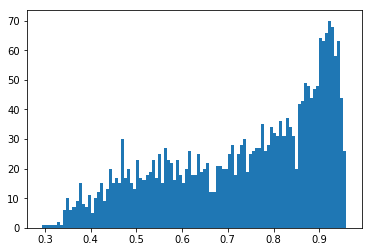

In [20]:
plt.hist(confidence, bins=100)

In [21]:
N = len(confidence)
confidence_order = np.argsort(-confidence)
sorted_error = (predictions[confidence_order]!=test_labels[confidence_order])
nb_errors = np.cumsum(sorted_error)
error_rate = nb_errors/np.arange(N)

/home/michel/.virtualenvs/solar/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


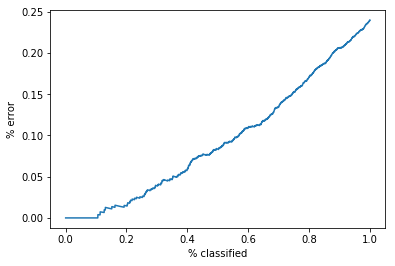

In [22]:
plt.plot(np.arange(N)/N, error_rate)
plt.xlabel('% classified')
plt.ylabel('% error')

In [23]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

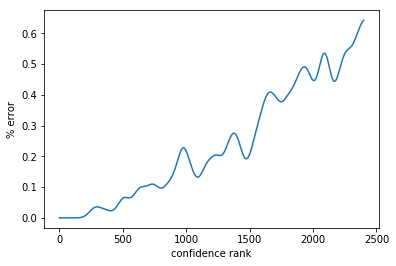

In [24]:
sigma = 40.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

smooth_error = custom_convolution(sorted_error, kernel)
plt.figure()
plt.plot(smooth_error)
plt.xlabel('confidence rank')
plt.ylabel('% error')

## Save model

In [28]:
import pickle
pickle.dump((model_cnn, model_lr, model_ensemble), open(models_filename, 'wb'))